In [1]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

DATA_ROOT = "../data"

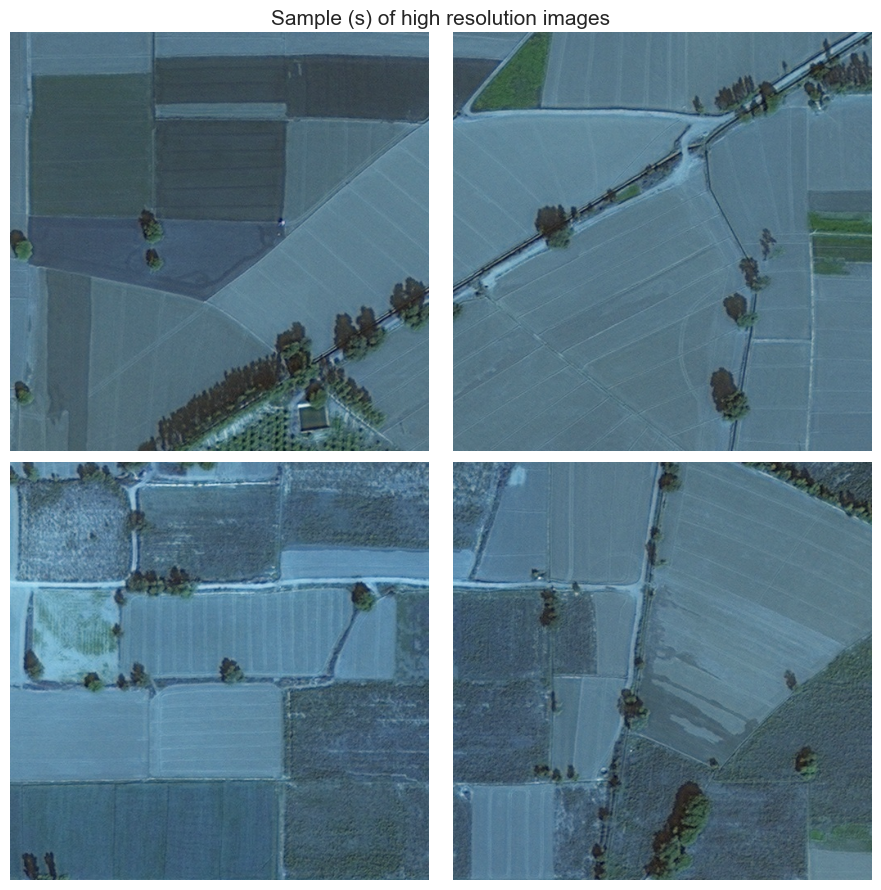

In [2]:
images_list = list(glob.glob(os.path.join(DATA_ROOT, "hotencode-test", "*.jpg")))
samples = [0,1,2,3]
fig, ax = plt.subplots(figsize = (9,9), nrows = 2, ncols =2)
for i, sample in enumerate(samples):
    r,c = divmod(i,2)
    ax[r,c].imshow(cv2.imread(images_list[sample])/255)
    ax[r,c].axis("off")
plt.suptitle("Sample (s) of high resolution images", fontsize = 15)
plt.tight_layout(pad=0.8)
plt.savefig("Samples.png")
plt.show()

[ 6  3 12 14 10  7 12  4]


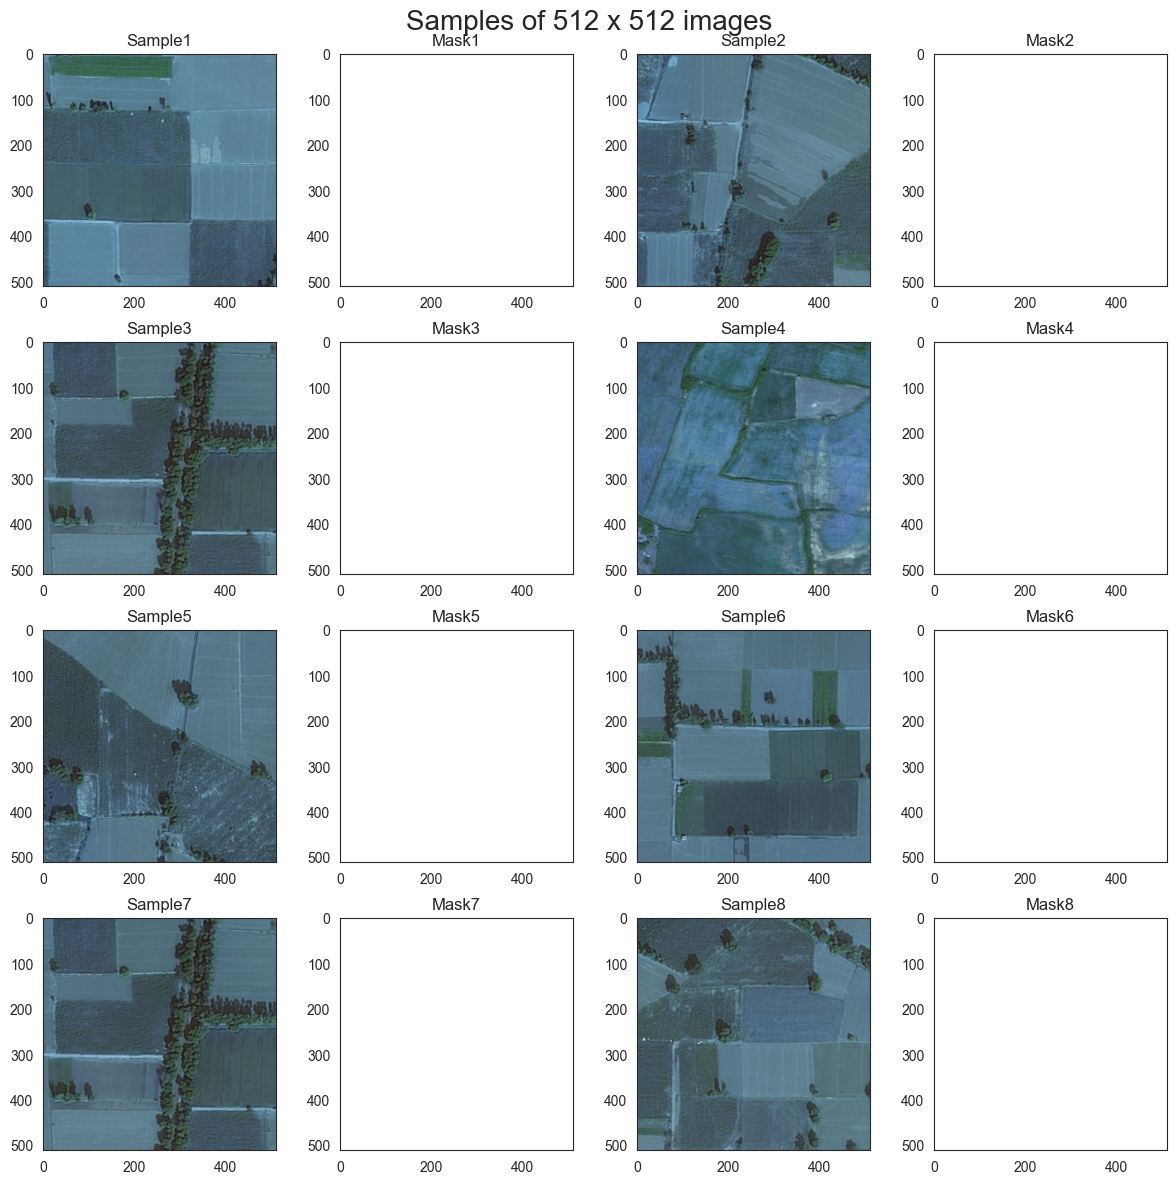

In [3]:
from utils import visualize_dataset
# TODO indicies festlegen indices = [0,1,17,20,29,5,6,7]
visualize_dataset(num_samples = 8, w = 12, h = 12, pad = 1.4,
                  save_title = "Visualize_dataset")

In [4]:
import torch
from torch.utils.data import DataLoader
from utils import SegmentationDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using " + device)

using cpu


** existing classes *

urban_land          0  ,255,255     1 
agriculture_land    255,255,0       6
rangeland           255,0  ,255     7
forest_land         0  ,255,0       2
water               0  ,0  ,255     3
barren_land         255,255,255     5
unknown             0  ,0  ,0       4

building (1), woodland (2), water(3), road(4)
->
building 1 -> 0,255,255 urban_land
woodland 2 -> 0,255,0   forest_land
water    3 -> 0,0,255   water
road     4 -> 0,0,0     unknown


In [5]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 8,num_workers =2)

class_dist = {"background":0, "urban_land":0,
              "forest_land":0, "water":0, "agriculture_land":0, "range_land":0, "barren_land":0}
label_mapping = {0: "background", 1: "urban_land",
                 2: "forest_land", 3: "water", 4: "agriculture_land", 5: "range_land", 6: "barren_land"}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

<class 'list'>
<class 'pandas.core.series.Series'>
Using the whole train set --> 15


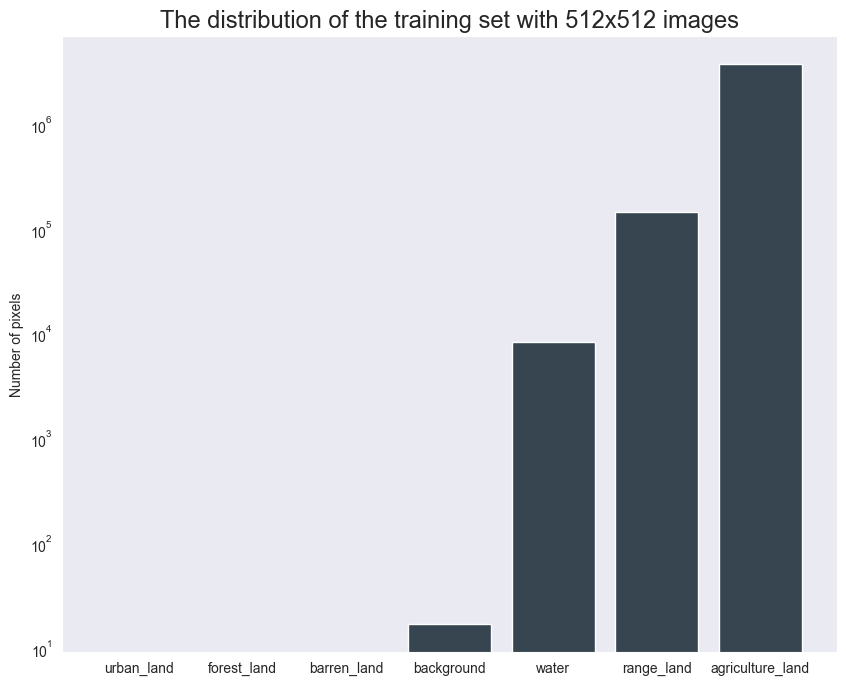

In [6]:
temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
labels = [x[0] for x in temp_list]
support = [x[1] for x in temp_list]

sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(labels, support, color = "#36454F")
ax.set_yscale("log")
ax.set_title("The distribution of the training set with 512x512 images",
             fontsize = 17)
ax.set_ylabel("Number of pixels")
plt.savefig("Barplt.png")
plt.show()

## AUGMENTATION

In [7]:
import albumentations as A

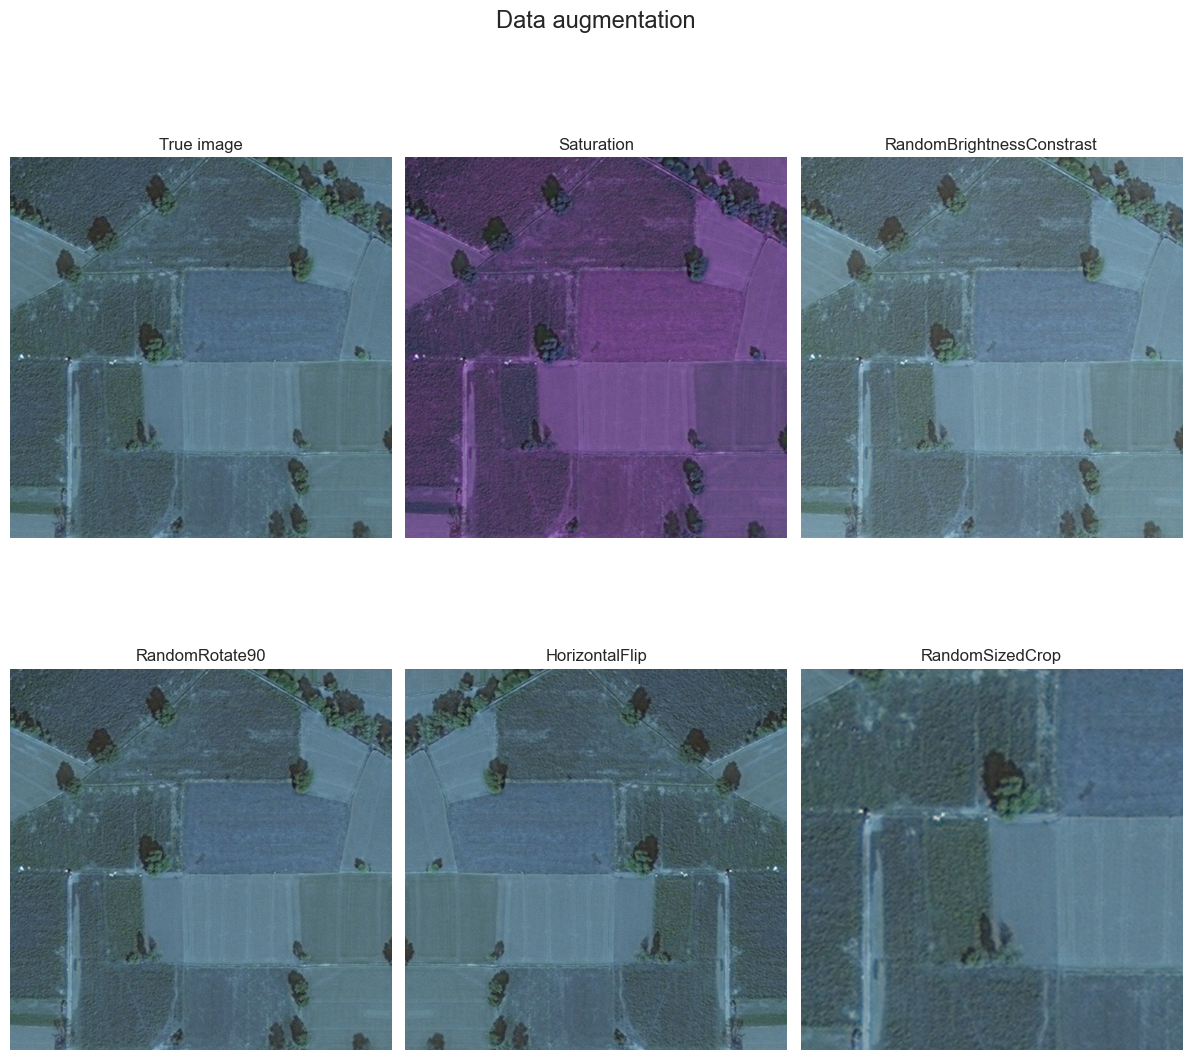

In [8]:
# Transformations
transforms = [A.HueSaturationValue(40, 40, 30, p=1),
              A.RandomBrightnessContrast(p=1, brightness_limit=0.2, contrast_limit=0.5),
              A.RandomRotate90(p=1), A.HorizontalFlip(p=1),
              A.RandomSizedCrop(min_max_height=(248, 512), height=512, width=512, p=1)]
transforms_names = ["Saturation", "RandomBrightnessConstrast",
                    "RandomRotate90", "HorizontalFlip", "RandomSizedCrop"]

# Read the NUM_SAMPLE sample in the training set
NUM_SAMPLE = 4
trainpath_list = list(glob.glob(os.path.join(os.getcwd(), "../data/hotencode-test", "*.jpg")))
img = cv2.imread(trainpath_list[NUM_SAMPLE])

fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=3)

ax[0, 0].imshow(img)
ax[0, 0].axis("off")
ax[0, 0].set_title("True image")
count = 0

for i in range(2):
    for j in range(3):
        if i + j == 0:
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j].set_title("True image")
        else:
            transformed_img = transforms[count](image=img)["image"]
            ax[i, j].imshow(transformed_img)
            ax[i, j].axis("off")
            ax[i, j].set_title(transforms_names[count])
            count += 1
plt.suptitle("Data augmentation", fontsize=17)
plt.tight_layout(pad=1)
plt.savefig("augmentations.png")
plt.show()

In [9]:
# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([
        A.HueSaturationValue(40,40,30,p=1),
        A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                   contrast_limit = 0.5)], p = 0.5),
    A.OneOf([
        A.RandomRotate90(p=1),
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
    ], p = 0.5)])

In [10]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
target_names = np.array(["unknown/background", "urban_land/building", "forest_land/woodland", "water", "agriculture_land", "range_land", "barren_land"])

# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass",
                                 classes = 7).to(device)

# Hyperparameters
batch_size = 8
epochs = 80
epochs = 1
lr = 5e-5

# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = transforms,
                                ratio = 0.6)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.7)

train_dloader = DataLoader(train_set, batch_size = batch_size,
                           shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

<class 'list'>
<class 'pandas.core.series.Series'>
Using the 60.00% of the initial train set --> 9|15
<class 'list'>
<class 'pandas.core.series.Series'>
Using the whole test set --> 15
<class 'list'>
<class 'pandas.core.series.Series'>
Using the 70.00% of the initial val set --> 10|15


In [12]:
from utils import training_loop
from utils import class_report
from utils import visualize_preds

In [13]:
model = smp.Unet(encoder_name = "resnet50",
                encoder_weights = "imagenet",
                classes = 7).to(device)

Training of UNet with Resnet encoder starts!
Using loss as stopping criterion.
Epoch: 1/1     Training Loss: 0.3345     Validation Loss: 0.3311
Validation loss decreased (inf --> 0.331081).  Saving model ...


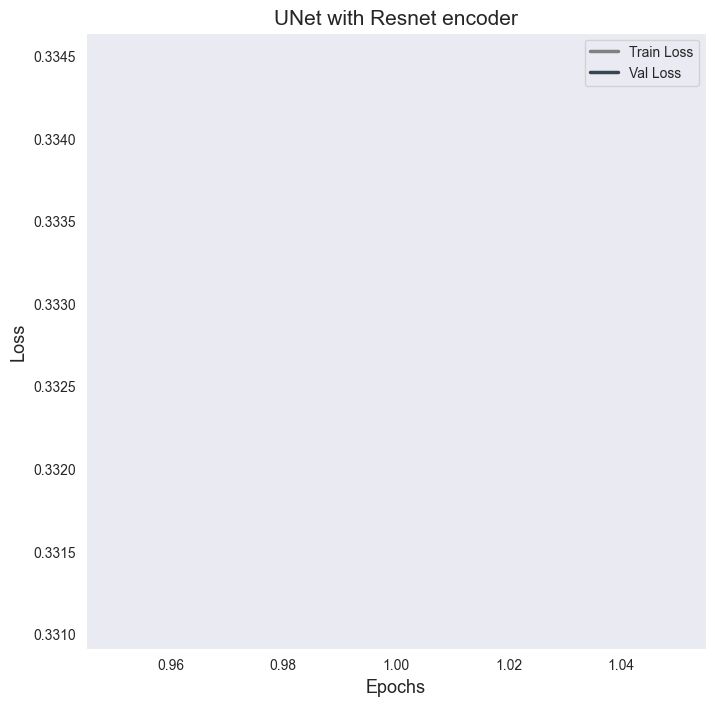


 Training completed in 1.0 m 11.39 s.


In [14]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
              regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
              patience = 5, verbose = True, model_title = "UNet with Resnet encoder", save = True,
              stopping_criterion = "loss")

In [ ]:
from utils import segmentation_test_loop
from utils import class_report

# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                                           device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

          precision          recall          f1-score          support


In [ ]:
from utils import visualize_preds

visualize_preds(model, test_set, title = "Predictions - UNet+Resnet50",
                save_title = "UNet+Resnet", h = 12, w = 12, indices = [957,961,1476,1578])